In [3]:
import pennylane as qml
from pennylane import numpy as np
import sys
sys.path.insert(0, '..')
from qoop.core.ansatz import chain_zxz_pennylane

def vqe(opt, num_layers):
    import pennylane.numpy as nps
    import pennylane as qml
    symbols = ["H", "H"]
    num_qubits = 3
    coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

    dev = qml.device("default.qubit", wires=qubits)

    chain_zxz_pennylane_func = chain_zxz_pennylane(num_qubits, num_layers)
    thetas = nps.random.uniform(0, 2*nps.pi, 4 * num_qubits * num_layers)

    @qml.qnode(dev, diff_method="parameter-shift")
    def cost_fn(thetas):
        j = 0
        for _ in range(0, num_layers):
            for i in range(0, num_qubits - 1):
                qml.CRY(thetas[j], wires=[i,i+1])
                j += 1
            qml.CRY(thetas[j], wires=[num_qubits - 1, 0])
            j += 1
            for i in range(0, num_qubits):
                qml.RZ(thetas[j], wires=i)
                qml.RX(thetas[j+1], wires=i)
                qml.RZ(thetas[j+2], wires=i)
                j += 3
        return qml.expval(H)


    # VQE Optimization Loop
    max_iterations = 10

    E_fci = -1.136189454088
    costs = []
    for i in range(max_iterations):
        thetas, cost = opt.step_and_cost(cost_fn, thetas)
        costs.append(cost)
    return costs

opt = qml.AdamOptimizer(stepsize=0.1)
costs = vqe(opt, 1)

In [7]:
class RCDOptimizer:
    def __init__(self, eta=0.01 , h=0.005):
        self.h = h
        self.eta = eta

    def step(self, objective_fn, theta):
        i = np.random.randint(theta.size)
        shape = theta.shape
        dt = np.eye(1,theta.size,i)
        theta = theta.reshape(-1)
        dtheta = (objective_fn((theta+dt*self.h).reshape(shape)) 
                    -objective_fn((theta-dt*self.h).reshape(shape)))/(2*self.h)
        return (theta - self.eta*dtheta*dt).reshape(shape)

    def step_and_cost(self, objective_fn, theta):
        theta = self.step(objective_fn, theta)
        return theta, objective_fn(theta)

opt = RCDOptimizer(eta=0.1, h=0.01)
costs_rcd = vqe(opt, 1)

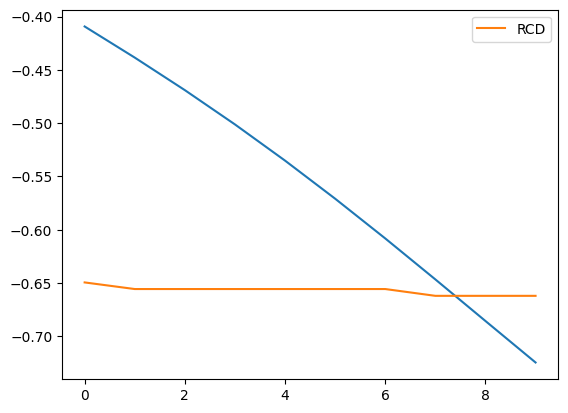

In [8]:
import matplotlib.pyplot as plt
plt.plot(costs)
plt.plot(costs_rcd, label="RCD")
plt.legend()

In [ ]:
drawer = qml.draw(chain_zxz_pennylane_func)(thetas)
print(drawer)

In [ ]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, ADAM, GradientDescent, AQGD
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms.gradients import thetashiftEstimatorGradient
optimizer = SLSQP(maxiter=60)
estimator = Estimator()
#algorithm_globals.random_seed = 50

driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.7",
        basis="631g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
mapper=JordanWignerMapper()
qubit_op = mapper.map(hamiltonian)
gradientor = thetashiftEstimatorGradient(estimator)
vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer, gradient = gradientor)
ene_vqe = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
print(ene_vqe)

/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_26233/568627938.py:11: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


-1.8816967632790051


In [34]:
import numpy as np
optimizers = [ADAM(maxiter=100, lr = 0.1, beta_1 = 0.8, beta_2 = 0.999, eps = 10**(-8)), 
              GradientDescent(maxiter=100, learning_rate = 0.1),
              ]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

def vqe_convergence(qc):
    for i, optimizer in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
        ansatz = qc

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)

        vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer, gradient = gradientor, callback=store_intermediate_result)
        #vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
        #          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(qubit_op)
        print(result.eigenvalue)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)
    return converge_cnts, converge_vals

Optimizer: ADAM        -1.8820882958622498
Optimizer: GradientDescent        -1.1654710874451597


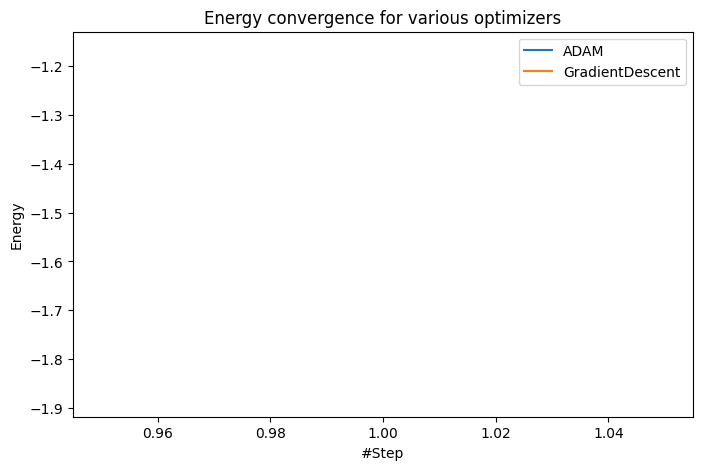

In [ ]:
import pylab

converge_cnts, converge_vals = vqe_convergence(qc)
pylab.rcthetas['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('#Step')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

-1.8820888154393793


In [7]:
driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.7",
        basis="631g",
        charge=0,
        spin=0
    )
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
optimizer = SLSQP(maxiter=1000)
estimator = Estimator()
mapper=JordanWignerMapper()
qubit_op = mapper.map(hamiltonian)
vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
computation_value = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real

/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_26233/2802137497.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
